In [1]:
import os
import pickle
import numpy as np
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, GRU, Dense 
print('TensorFlow',tf.__version__)

TensorFlow 2.0.0


## Loading the dataset using tensorflow_datasets 

In [2]:
import pandas as pd
data=pd.read_csv('fra.txt',header=None,sep='\t')
dataset=data.drop(columns = [2])
dataset=dataset.sample(8000).reset_index(drop=True)  
dataset.head()

,0,1
0,We took a taxi so we wouldn't be late.,Nous avons pris un taxi pour ne pas être en re...
1,Are you in any of those pictures?,Es-tu sur une de ces photos ?
2,I have a lot of passwords to remember.,Il y a beaucoup de mots de passe dont je dois ...
3,Do you have the same thing in a different color?,As-tu la même chose dans une couleur différente ?
4,The petals floated on the surface of the water.,Les pétales flottaient à la surface de l'eau.


In [3]:
NUM_SAMPLES = len(dataset)
NUM_SAMPLES

8000

## Adding start and end sequence markers

In [4]:
dataset[0][1]

'Are you in any of those pictures?'

In [5]:
en_sentences = []
fr_sentences = []
for i in tqdm(range(NUM_SAMPLES)):
    en_sentences.append(dataset[0][i])
    fr_sentences.append('startseq ' + dataset[1][i] + ' endseq')
en_sentences[:5],fr_sentences[:5]

100%|██████████| 8000/8000 [00:00<00:00, 35774.18it/s]


(["We took a taxi so we wouldn't be late.",
  'Are you in any of those pictures?',
  'I have a lot of passwords to remember.',
  'Do you have the same thing in a different color?',
  'The petals floated on the surface of the water.'],
 ['startseq Nous avons pris un taxi pour ne pas être en retard. endseq',
  'startseq Es-tu sur une de ces photos\xa0? endseq',
  'startseq Il y a beaucoup de mots de passe dont je dois me rappeler. endseq',
  'startseq As-tu la même chose dans une couleur différente ? endseq',
  "startseq Les pétales flottaient à la surface de l'eau. endseq"])

## Tokenization

In [6]:
en_tk = Tokenizer(num_words=5000)
fr_tk = Tokenizer(num_words=5000)

with open('en.pkl', 'wb') as f:
    pickle.dump(en_tk, f)

with open('fr.pkl', 'wb') as f:
    pickle.dump(fr_tk, f)
    
en_tk.fit_on_texts(en_sentences)
fr_tk.fit_on_texts(fr_sentences)    

In [7]:
# with open('en.pkl', 'rb') as f:
#     en_tk = pickle.load( f)

# with open('fr.pkl', 'rb') as f:
#     fr_tk = pickle.load(f)

## Visualizing sequence lenghts

English sentences : mean = 6.16975, std = 2.5116100289455767, max = 25
Franch sentences : mean = 8.721375, std = 2.786394284622153, max = 30


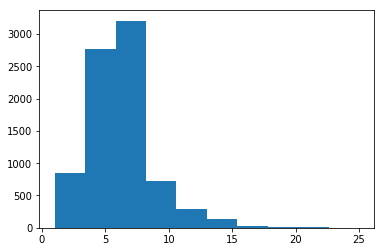

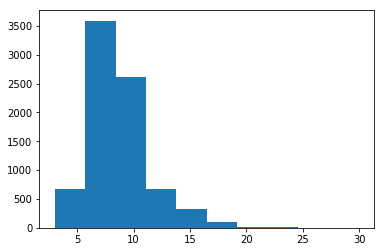

In [8]:
en_lens = [len(x.split()) for x in en_sentences]
fr_lens = [len(x.split()) for x in fr_sentences]

plt.figure()
plt.hist(en_lens)

plt.figure()
plt.hist(fr_lens)

en_mean = np.mean(en_lens)
en_std = np.std(en_lens)
fr_mean = np.mean(fr_lens)
fr_std = np.std(fr_lens)
en_max = np.max(en_lens)
fr_max = np.max(fr_lens)

print(f'English sentences : mean = {en_mean}, std = {en_std}, max = {en_max}')
print(f'Franch sentences : mean = {fr_mean}, std = {fr_std}, max = {fr_max}')

In [9]:
max_sequence_len = 30
en_vocab_size = 5000
fr_vocab_size =5000

## Tokenization and sequence padding

In [10]:
def preprocess_en(en):
    encoded_en = en_tk.texts_to_sequences(en)
    padded_en = pad_sequences(encoded_en, maxlen=max_sequence_len, padding='post', truncating='post')
    return padded_en

def preprocess_fr(fr):
    encoded_fr = fr_tk.texts_to_sequences(fr)
    padded_fr = pad_sequences(encoded_fr, maxlen=max_sequence_len, padding='post', truncating='post')
    return padded_fr

def preprocess_text(en, fr):
    return preprocess_en(en.numpy().decode()), preprocess_fr(fr.numpy().decode())

## Preparing training dataset

In [11]:
train_en = preprocess_en(en_sentences)
train_fr = preprocess_fr(fr_sentences)

batch_size = 64
train_dataset = tf.data.Dataset.from_tensor_slices((train_en, train_fr))
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(1024)
train_dataset = train_dataset.batch(batch_size, drop_remainder=True)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

## Defininf Encoder, Decoder and Attention models using tf.keras model subclassing

In [12]:
class Encoder(tf.keras.Model):
    def __init__(self, hidden_size=1024, max_sequence_len=30, batch_size=batch_size, embedding_dim=256, vocab_size=5000):
        super(Encoder, self).__init__()
        self.embedding_dim = embedding_dim
        self.vocab_size = vocab_size
        self.max_sequence_len = max_sequence_len
        self.hidden_size = hidden_size
        self.batch_size = batch_size

        self.embedding_layer = Embedding(
            input_dim=self.vocab_size, output_dim=self.embedding_dim)
        self.GRU_1 = GRU(units=hidden_size, return_sequences=True)
        self.GRU_2 = GRU(units=hidden_size,
                         return_sequences=True, return_state=True)

    def initial_hidden_state(self):
        return tf.zeros(shape=(self.batch_size, self.hidden_size))

    def call(self, x, initial_state, training=False):
        x = self.embedding_layer(x)
        x = self.GRU_1(x, initial_state=initial_state)
        x, hidden_state = self.GRU_2(x)
        return x, hidden_state

注意力机制
在 Attention 机制下，语义编码 C 就不在是输入序列的直接编码了，而是各个元素按其重要程度加权求和得到的，即：
$$C_i=\sum_{j=0}^{T_x}{a_{ij}h_j}$$
在上述公式中，参数i表示时刻， j表示序列中的第j个元素， $T_x$表示序列的长度，$a_{ij}$可以看作是一个概率，反映了元素$h_j对$C_i$的重要性，可以使用 softmax 来表示：
$$a_{ij}=\frac{exp(e_{ij})}{\sum_{k=1}^{T_x}exp(e_{ik})}$$

这里$e_{ij}$正是反映了待编码的元素和其它元素之间的匹配度，当匹配度越高时，说明该元素对其的影响越大，则$a_{ij}$的值也就越大。

In [13]:
class Attention(tf.keras.Model):
    def __init__(self, hidden_size=256):
        super(Attention, self).__init__()
        self.fc1 = Dense(units=hidden_size)
        self.fc2 = Dense(units=hidden_size)
        self.fc3 = Dense(units=1)

    def call(self, encoder_output, hidden_state, training=False):
        '''hidden_state : h(t-1)'''
        y_hidden_state = tf.expand_dims(hidden_state, axis=1)
        y_hidden_state = self.fc1(y_hidden_state)
        y_enc_out = self.fc2(encoder_output)
        
        #get a_ij
        y = tf.keras.backend.tanh(y_enc_out + y_hidden_state)
        attention_score = self.fc3(y)
        attention_weights = tf.keras.backend.softmax(attention_score, axis=1)
        
        #get c_i
        context_vector = tf.multiply(encoder_output, attention_weights)
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [14]:
class Decoder(tf.keras.Model):
    def __init__(self, hidden_size=1024, max_sequence_len=30, batch_size=batch_size, embedding_dim=256, vocab_size=5000):
        super(Decoder, self).__init__()
        self.embedding_dim = embedding_dim
        self.vocab_size = vocab_size
        self.max_sequence_len = max_sequence_len
        self.hidden_size = hidden_size
        self.batch_size = batch_size
    
        self.embedding_layer = Embedding(
            input_dim=self.vocab_size, output_dim=self.embedding_dim)
        self.GRU = GRU(units=hidden_size,
                       return_sequences=True, return_state=True)
        self.attention = Attention(hidden_size=self.hidden_size)
        self.fc = Dense(units=self.vocab_size)

    def initial_hidden_state(self):
        return tf.zeros(shape=(self.batch_size, self.hidden_size))

    def call(self, x, encoder_output, hidden_state, training=False):
        x = self.embedding_layer(x)
        context_vector, attention_weights = self.attention(
            encoder_output, hidden_state, training=training)
        contect_vector = tf.expand_dims(context_vector, axis=1)
        x = tf.concat([x, contect_vector], axis=-1)
        x, curr_hidden_state = self.GRU(x)
        x = tf.reshape(x, shape=[self.batch_size, -1])
        x = self.fc(x)
        return x, curr_hidden_state, attention_weights

## Defining training loop, loss function and optimizer

In [15]:
loss_object = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)
train_accuracy = tf.metrics.SparseCategoricalAccuracy()


def loss_function(y_true, y_pred):
    loss = loss_object(y_true, y_pred)
    mask = 1 - tf.cast(tf.equal(y_true, 0), 'float32')
    return tf.reduce_mean(loss * mask)
    
@tf.function()
def training_step(en, fr):    
    with tf.GradientTape() as Tape:
        encoder_init_state = encoder.initial_hidden_state()
        encoder_output, encoder_hidden_state = encoder(en, encoder_init_state, training=True)
        decoder_hidden = encoder_hidden_state
        loss = 0
        acc = []
        current_word = tf.expand_dims(fr[:, 0], axis=1)
        for word_idx in range(1, max_sequence_len):
            next_word = fr[:, word_idx]
            logits, decoder_hidden, attention_weights = decoder(current_word, encoder_output, decoder_hidden, training=True)
            loss += loss_function(next_word, logits)
            acc.append(train_accuracy(next_word, logits))
            current_word = tf.expand_dims(next_word, axis=1)
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = Tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    return loss, tf.reduce_mean(acc)

In [16]:
encoder = Encoder()
decoder = Decoder()
checkpoint_dir = 'training'
checkpoint_prefix = 'training/ckpt'
checkpoint = tf.train.Checkpoint(optimizer=optimizer, encoder=encoder, decoder=decoder)

## Training the model

In [17]:
epochs = 4
num_steps = NUM_SAMPLES // batch_size
for epoch in range(1, epochs + 1):
    print(f'Epoch {epoch}/{epochs}')
    ep_loss = []
    ep_acc = []
    progbar = tf.keras.utils.Progbar(target=num_steps, stateful_metrics=[
                                     'curr_loss', 'curr_accuracy'], unit_name='batch')

    for step, example in enumerate(train_dataset):
        en = example[0]
        fr = example[1]
        loss, acc = training_step(en, fr)
        loss /= fr.shape[1]
        ep_loss.append(loss)
        ep_acc.append(acc)
        progbar.update(
            step + 1, values=[('curr_loss', loss), ('curr_accuracy', acc)])

    if epoch % 1 == 0:
        checkpoint.save(file_prefix=checkpoint_prefix)
    print(f'Metrics after epoch {epoch} : Loss => {np.mean(ep_loss):.3f} | Accuracy => {np.mean(ep_acc):.3f}')
checkpoint.save(file_prefix=checkpoint_prefix)

Epoch 1/4
125/125 [==============================] - 1266s 10s/batch - curr_loss: 1.0478 - curr_accuracy: 0.7373
Metrics after epoch 1 : Loss => 1.294 | Accuracy => 0.664
Epoch 2/4
125/125 [==============================] - 1289s 10s/batch - curr_loss: 1.0233 - curr_accuracy: 0.7633
Metrics after epoch 2 : Loss => 1.081 | Accuracy => 0.752
Epoch 3/4
125/125 [==============================] - 1161s 9s/batch - curr_loss: 0.8113 - curr_accuracy: 0.7759
Metrics after epoch 3 : Loss => 0.970 | Accuracy => 0.769
Epoch 4/4
125/125 [==============================] - 1933s 15s/batch - curr_loss: 0.7466 - curr_accuracy: 0.7845
Metrics after epoch 4 : Loss => 0.889 | Accuracy => 0.780


'training/ckpt-5'

In [18]:
checkpoint.restore('training/ckpt-4')

## Inference function

In [30]:
def translate_sentence(sentence):
    print(sentence)
    sentence = preprocess_en([sentence])
    enc_init = tf.zeros(shape=[1, 1024])
    enc_out, enc_hidden = encoder(sentence, enc_init)

    decoder.batch_size = 1
    fr_tk.index_word[0] = ''
    decoded = []
    att = []
    current_word = tf.expand_dims([fr_tk.word_index['startseq']], axis=0) 
    decoder_hidden = enc_hidden
    for word_idx in range(1, max_sequence_len):
        logits, decoder_hidden, attention_weights = decoder(current_word, enc_out, decoder_hidden)
        decoded_idx = np.argmax(logits)
        if fr_tk.index_word[decoded_idx] == 'endseq':
            break
        decoded.append(fr_tk.index_word[decoded_idx])
        
        att.append(attention_weights.numpy().squeeze())
        current_word = tf.expand_dims([decoded_idx], axis=0)
    return ' '.join(decoded), att

## Translating and visualizing Attention maps

There is a misunderstanding
EN :  There is a misunderstanding
FR :  il est la
------------------------------
what do you want ?
EN :  what do you want ?
FR :  pourquoi vous êtes vous
------------------------------
are you mad ?
EN :  are you mad ?
FR :  vous êtes
------------------------------
state of the art
EN :  state of the art
FR :  ils
------------------------------
the exam is going to be hard
EN :  the exam is going to be hard
FR :  la monde est
------------------------------
do you want to play with me ?
EN :  do you want to play with me ?
FR :  pourquoi vous êtes vous
------------------------------
i love you
EN :  i love you
FR :  je vous
------------------------------
how are you doing ?
EN :  how are you doing ?
FR :  pourquoi vous êtes vous
------------------------------
i should tell you that i am quite dangerous
EN :  i should tell you that i am quite dangerous
FR :  je n'ai pas que vous me faire ce que vous
------------------------------
Do you have any idea of how to

<Figure size 288x216 with 0 Axes>

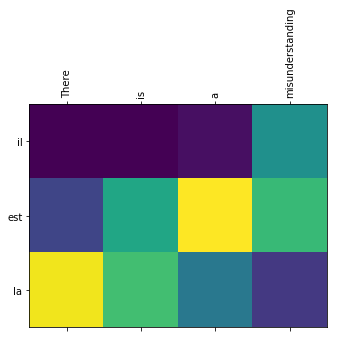

<Figure size 360x288 with 0 Axes>

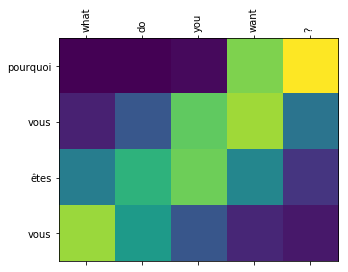

<Figure size 288x144 with 0 Axes>

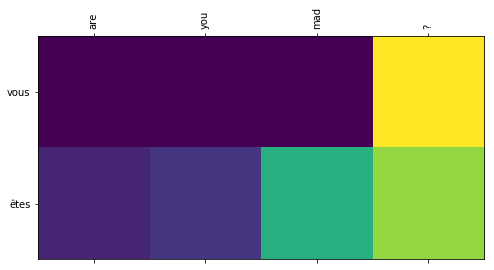

<Figure size 288x72 with 0 Axes>

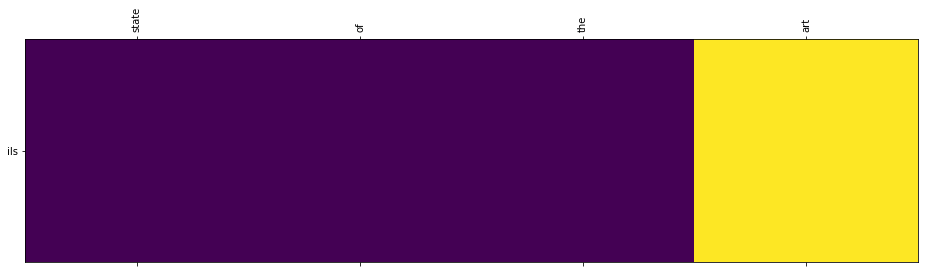

<Figure size 504x216 with 0 Axes>

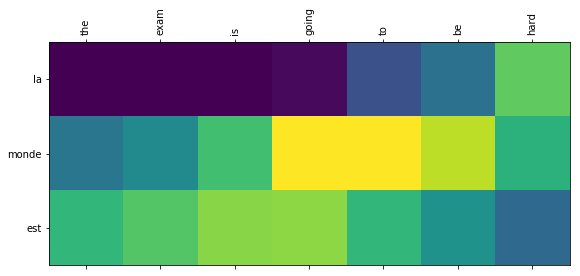

<Figure size 576x288 with 0 Axes>

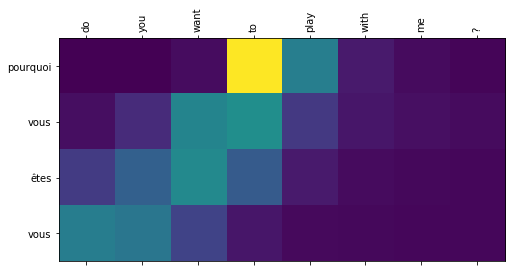

<Figure size 216x144 with 0 Axes>

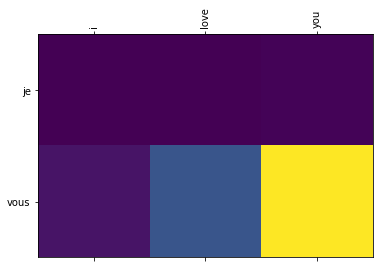

<Figure size 360x288 with 0 Axes>

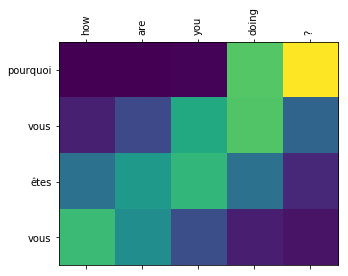

<Figure size 648x720 with 0 Axes>

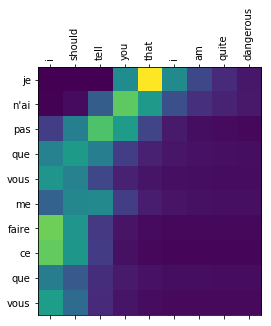

<Figure size 792x288 with 0 Axes>

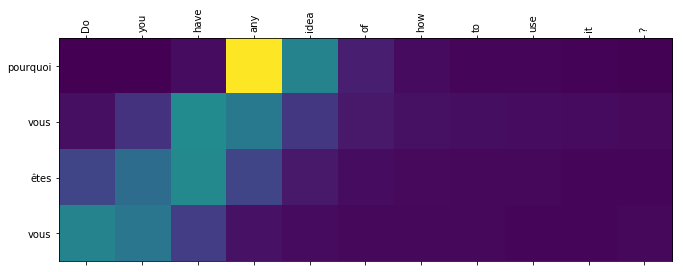

In [43]:
sentences = ['There is a misunderstanding',
             'what do you want ?',
             'are you mad ?',
             'state of the art',
             'the exam is going to be hard', 
             'do you want to play with me ?','i love you', 
             'how are you doing ?', 
             'i should tell you that i am quite dangerous', 
             'Do you have any idea of how to use it ?']

for inp_sentence in sentences:
    inp_array = inp_sentence.split()
    inp_len = len(inp_sentence.split())
    trans_sentence, attention_weights = translate_sentence(inp_sentence)
    #print("",attention_weights)
    trans_array = trans_sentence.split()
    trans_len = len(trans_array)
    attention_weights = np.array([x for x in attention_weights])
    
    attention_weights = attention_weights[:trans_len,:inp_len]
    plt.figure(figsize=(inp_len, trans_len))
    plt.matshow(attention_weights)
    plt.xticks(range(inp_len), inp_array, rotation=90)
    plt.yticks(range(trans_len), trans_array)
    print('EN : ', inp_sentence)
    print('FR : ', trans_sentence)
    print('-'*30)